In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

Load Data Set

In [4]:
df = pd.read_csv('../Data/credit_scoring_sample.csv', sep=';')
df

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0
...,...,...,...,...,...,...,...,...
45058,1,31,0,0.824725,0,0,3000.0,1.0
45059,0,49,0,6530.000000,0,0,0.0,5.0
45060,1,38,0,0.475841,0,0,3000.0,2.0
45061,0,47,1,0.485198,0,0,11720.0,5.0


Plot SeriousDlqin2yrs Histogram

<Axes: xlabel='SeriousDlqin2yrs', ylabel='Count'>

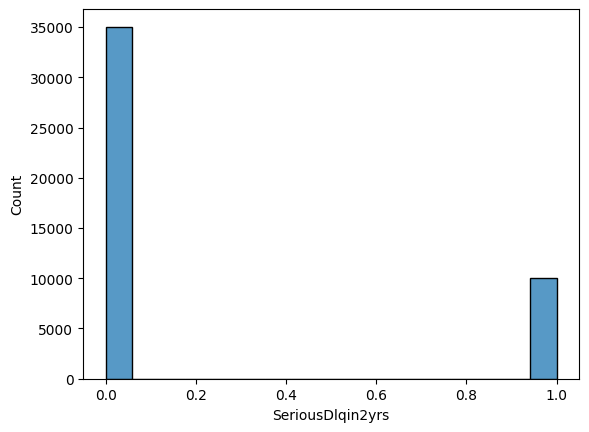

In [7]:
sns.histplot(data=df, x="SeriousDlqin2yrs")

Pre Processing Data Set

In [9]:
imputer = SimpleImputer(strategy='median')
cols = ['SeriousDlqin2yrs', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse', 'MonthlyIncome', 'NumberOfDependents']
df[cols] = imputer.fit_transform(df[cols])
df

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0.0,64.0,0.0,0.249908,0.0,0.0,8158.0,0.0
1,0.0,58.0,0.0,3870.000000,0.0,0.0,5166.0,0.0
2,0.0,41.0,0.0,0.456127,0.0,0.0,6666.0,0.0
3,0.0,43.0,0.0,0.000190,0.0,0.0,10500.0,2.0
4,1.0,49.0,0.0,0.271820,0.0,0.0,400.0,0.0
...,...,...,...,...,...,...,...,...
45058,1.0,31.0,0.0,0.824725,0.0,0.0,3000.0,1.0
45059,0.0,49.0,0.0,6530.000000,0.0,0.0,0.0,5.0
45060,1.0,38.0,0.0,0.475841,0.0,0.0,3000.0,2.0
45061,0.0,47.0,1.0,0.485198,0.0,0.0,11720.0,5.0


Boot-Strapping

In [11]:
means = []
num_of_samples = 100
sample_size = 1000
dishonest_customers = df[df['SeriousDlqin2yrs'] == 1]

for i in range(num_of_samples):
    sample = dishonest_customers.sample(n=sample_size, replace=True, random_state=None)
    means.append(sample['age'].mean())

mean = np.mean(means)
std = np.std(means)
z_score = 1.644854
Interval = std/np.sqrt(num_of_samples)
Interval = Interval * z_score
print(f"90 percent confidence interval: [{mean - Interval} , {mean + Interval}]")

90 percent confidence interval: [45.879591388357326 , 46.01078861164268]


Random Forest

In [13]:
data = df.drop('SeriousDlqin2yrs', axis=1).to_numpy()
target = df['SeriousDlqin2yrs']

random_forest = RandomForestClassifier(n_estimators=100, class_weight='balanced')
parameters = {'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5, 10, 15] }
classifier = GridSearchCV(random_forest, parameters, n_jobs=16)

skf = StratifiedKFold(n_splits=5, shuffle=True)
best_parameter = []

for train_index, test_index in skf.split(data, target):
    print(len(best_parameter))
    y_train_fold = target[train_index]
    x_train_fold = data[train_index]
    classifier.fit(x_train_fold, y_train_fold)
    best_parameter.append(classifier.best_params_)

best_parameter

0
1
2
3
4


[{'max_depth': 15, 'max_features': 1, 'min_samples_leaf': 3},
 {'max_depth': 15, 'max_features': 2, 'min_samples_leaf': 3},
 {'max_depth': 15, 'max_features': 4, 'min_samples_leaf': 3},
 {'max_depth': 15, 'max_features': 4, 'min_samples_leaf': 3},
 {'max_depth': 15, 'max_features': 2, 'min_samples_leaf': 3}]

Calculate ROC AUC

In [15]:
optimized_random_forest = RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth=15, max_features=1, min_samples_leaf=3 )
skf = StratifiedKFold(n_splits=5, shuffle=True)
roc_auc_values = []

for train_index, test_index in skf.split(data, target):
    y_train_fold, y_test_fold = target[train_index], target[test_index]
    x_train_fold, x_test_fold = data[train_index], data[test_index]
    optimized_random_forest.fit(x_train_fold, y_train_fold)
    y_pred_probability = optimized_random_forest.predict_proba(x_test_fold)[:, 1] 
    roc_auc = roc_auc_score(y_test_fold, y_pred_probability)
    roc_auc_values.append(roc_auc)

[print(f"ROC AUC {i} : {roc_auc_values[i]}") for i in range(len(roc_auc_values))]

ROC AUC 0 : 0.833518159509901
ROC AUC 1 : 0.8310143234949158
ROC AUC 2 : 0.8238320574170168
ROC AUC 3 : 0.8339836508343812
ROC AUC 4 : 0.8239447406885954


[None, None, None, None, None]

Bagging

In [16]:
data = df.drop('SeriousDlqin2yrs', axis=1).to_numpy()
target = df['SeriousDlqin2yrs']

base_classifier = LogisticRegression(max_iter=200)
bagging_cl = BaggingClassifier(base_classifier, 100)
parameters = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 'estimator__C': [0.0001, 0.001, 0.01, 1, 10, 100] }

random_search = RandomizedSearchCV(bagging_cl, parameters, n_iter=20, n_jobs=16)

skf = StratifiedKFold(n_splits=5, shuffle=True)
best_params = []

for train_index, test_index in skf.split(data, target):
    print(len(best_params))
    y_train_fold = target[train_index]
    x_train_fold = data[train_index]
    random_search.fit(x_train_fold, y_train_fold)
    best_params.append(random_search.best_params_)

best_params

0
1
2
3
4


[{'max_samples': 0.7, 'max_features': 4, 'estimator__C': 1},
 {'max_samples': 0.7, 'max_features': 4, 'estimator__C': 10},
 {'max_samples': 0.5, 'max_features': 4, 'estimator__C': 1},
 {'max_samples': 0.5, 'max_features': 4, 'estimator__C': 1},
 {'max_samples': 0.5, 'max_features': 4, 'estimator__C': 1}]

Calculate ROC AUC

In [17]:
base_classifier = LogisticRegression(C=100, max_iter=200)
bagging_cl = BaggingClassifier(base_classifier, 100, max_samples=0.7, max_features=4)

data = df.drop('SeriousDlqin2yrs', axis=1).to_numpy()
target = df['SeriousDlqin2yrs']

skf = StratifiedKFold(n_splits=5, shuffle=True)
roc_auc_values = []

for train_index, test_index in skf.split(data, target):
    y_train_fold, y_test_fold = target[train_index], target[test_index]
    x_train_fold, x_test_fold = data[train_index], data[test_index]
    bagging_cl.fit(x_train_fold, y_train_fold)
    y_pred_probability = bagging_cl.predict_proba(x_test_fold)[:, 1] 
    roc_auc = roc_auc_score(y_test_fold, y_pred_probability)
    roc_auc_values.append(roc_auc)

[print(f"ROC AUC {i} : {roc_auc_values[i]}") for i in range(len(roc_auc_values))]

ROC AUC 0 : 0.7512569176374133
ROC AUC 1 : 0.7472883146016238
ROC AUC 2 : 0.7697435380457742
ROC AUC 3 : 0.772792864420937
ROC AUC 4 : 0.7450728822299895


[None, None, None, None, None]